Allison Aprile

CPE645 Final Project

Dog Camera - Method Exploration

# Edge Detection Based
* Idea that single intensity value cannot provide adequate information, especially in noisier images
* Based on large changes in intensity values over a short frequency 
  - First locate edges where either the first derivative of intensity is greater than a particular threshold or second derivative has zero crossings
  - Edges are detected then connected to form boundaries; can use **Hough Transform** or **Morphological transformations** such as opening, closing, erosion and gradient to achieve edge linking
  - Methods include **Laplacian, Sobel, Prewitt, and Canny** filters

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Mount drive for testing images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load testing files in grayscale
test1 = cv2.imread('/content/drive/My Drive/Aprile_CPE695_Final_Project/test_images/test1.jpg', 0)
test2 = cv2.imread('/content/drive/My Drive/Aprile_CPE695_Final_Project/test_images/test2.jpg', 0)
test3 = cv2.imread('/content/drive/My Drive/Aprile_CPE695_Final_Project/test_images/test3.jpg', 0)
test4 = cv2.imread('/content/drive/My Drive/Aprile_CPE695_Final_Project/test_images/test4.jpg', 0)
test5 = cv2.imread('/content/drive/My Drive/Aprile_CPE695_Final_Project/test_images/test5.jpg', 0)
test6 = cv2.imread('/content/drive/My Drive/Aprile_CPE695_Final_Project/test_images/test6.jpg', 0)
test7 = cv2.imread('/content/drive/My Drive/Aprile_CPE695_Final_Project/test_images/test7.jpg', 0)

test_imgs = [test1, test2, test3, test4, test5, test6, test7]

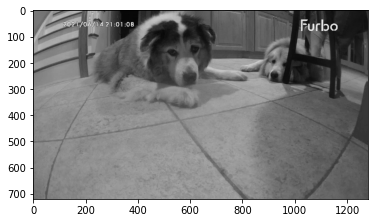

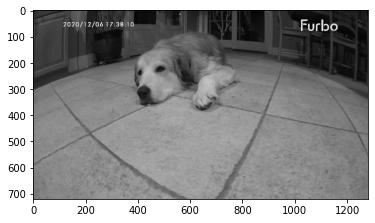

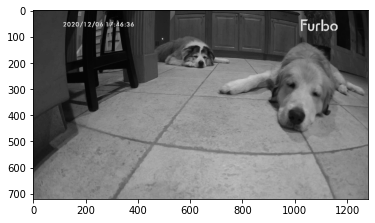

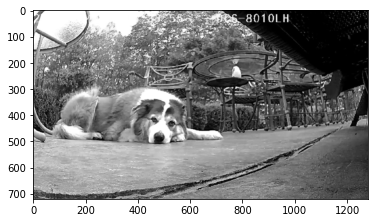

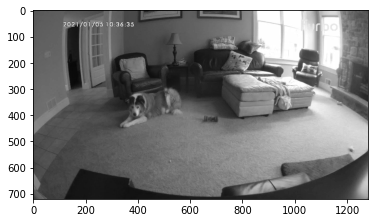

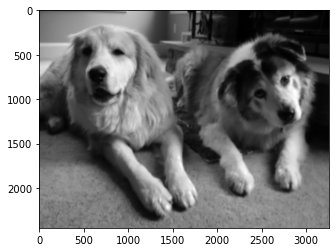

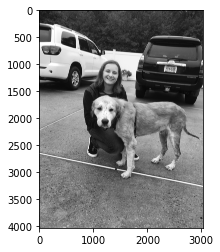

In [ ]:
# Plot images
for t in test_imgs:
  plt.imshow(t, cmap='gray')
  plt.show()

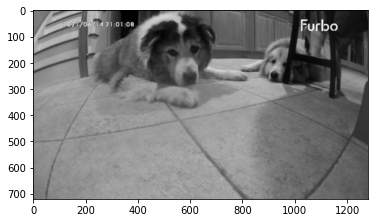

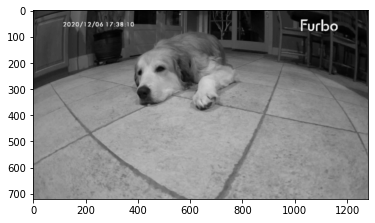

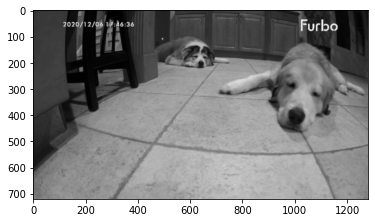

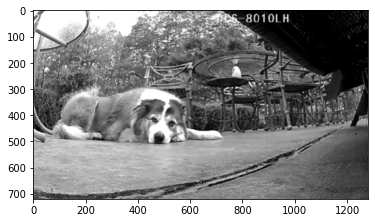

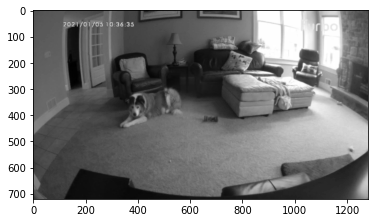

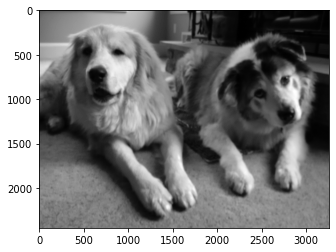

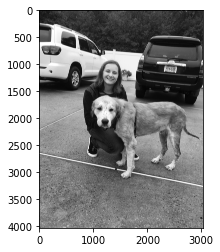

In [ ]:
smoothed_imgs = []
# Apply Gaussian smoothing on images with 5x5 filter
for i in range(len(test_imgs)):
  t = cv2.GaussianBlur(test_imgs[i], (5, 5), 0)
  smoothed_imgs.append(t)

  # Plot
  plt.imshow(t, cmap='gray')
  plt.show()

### 1. Laplacian
(https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Gradient_Sobel_Laplacian_Derivatives_Edge_Detection.php)

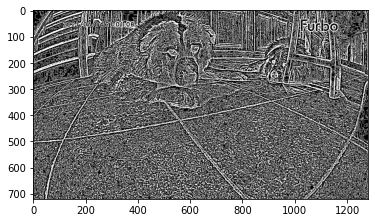

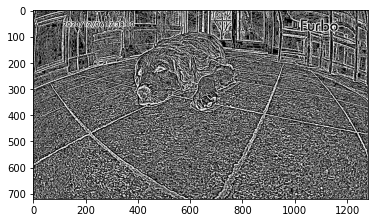

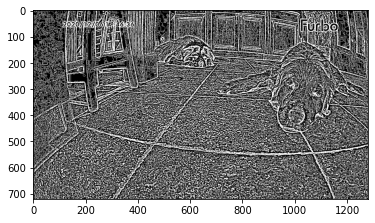

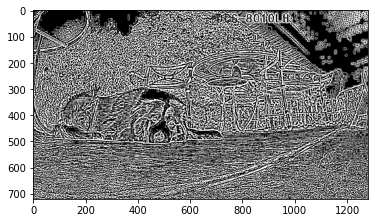

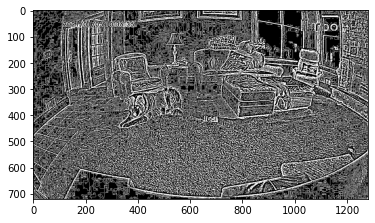

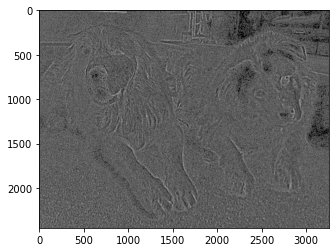

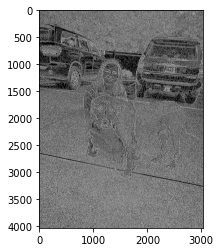

In [ ]:
# Show each image with the applied filter
for t in smoothed_imgs:
  laplacian = cv2.Laplacian(t, cv2.CV_64F)

  # Threshold to better see results
  _, laplacian = cv2.threshold(laplacian, 0, 255, cv2.THRESH_BINARY)
  plt.imshow(laplacian, cmap='gray')
  plt.show()

### 2. Sobel Gradient
(https://learnopencv.com/edge-detection-using-opencv/)

(CPE646-8)
* Two filters: one for horizontal (x) detection and the other for vertical (y) detection
* Can compute _gradient magnitude_ by taking the square root of the sum of the squared x and y gradients, or for a lighter computation, the sum of their absolute values

In [ ]:
# Define gradient magnitude computation function
def compute_magnitude(x, y, method):
  if method == 0:
    return abs(x) + abs(y)
  if method == 1:
    return np.sqrt(np.square(x) + np.square(y))

names = ['|Gx| + |Gy|', 'sqrt(Gx^2 + Gy^2)']

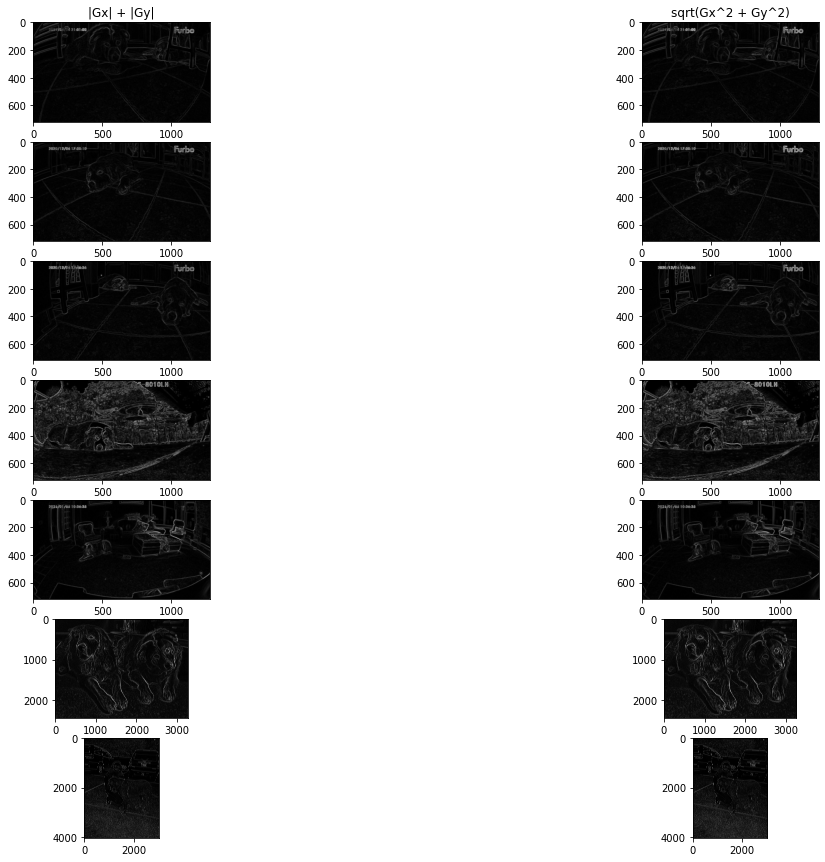

In [ ]:
# Show each image with the applied filter
fig, axs = plt.subplots(len(smoothed_imgs), len(names))
fig.set_size_inches(20, 15)
for i in range(len(smoothed_imgs)):
  for j in range(len(names)):
    # Compute Sobel x and y
    sobel_x = cv2.Sobel(smoothed_imgs[i], cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(smoothed_imgs[i], cv2.CV_64F, 0, 1, ksize=5)

    # Compute gradient magnitude
    mag = compute_magnitude(sobel_x, sobel_y, j)

    axs[i, j].imshow(mag, cmap='gray')

    if i == 0:
      axs[i, j].set_title(names[j])

plt.show()

### 3. Canny
(https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html)

(https://learnopencv.com/edge-detection-using-opencv/)

(https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/)

* Four step algorithm:
  - Noise reduction (so no need for Gaussian smoothing preprocessing; it is built-in)
  - Compute magnitude gradient using Sobel kernels 
  - Non-maximum suppression for false edges
    - Compare pixels in + and - gradient directions, setting pixel intensity to 0 if its gradient magnitude is less than the neighboring pixels (unchanged if greater)
  - Hysteresis Thresholding (gradient magnitudes are compared with two threshold values - one smaller than the other); determines if pixels are suppressed or included in final edge map

* Can do Automatic Canny detection by setting sigma to 0.33 (standard amongst ML engineers), and compute upper and lower threshold values by scaling the median of all pixel intensities in an image
  - Lower sigma --> tighter threshold

In [ ]:
# Define automatic Canny function
def automatic_canny(img, sigma=0.33):
  # Compute the median of all pixel values in an image
  med = np.median(img)

  # Compute lower and upper thresholds
  lower = int(max(0, (1.0 - sigma) * med))
  upper = int(min(255, (1.0 + sigma) * med))

  # Compute Canny edge map
  edges = cv2.Canny(img, lower, upper)

  return edges

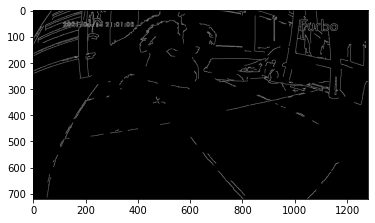

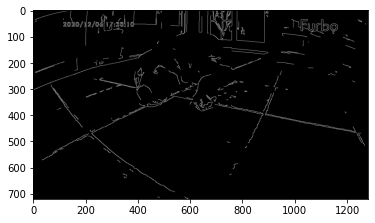

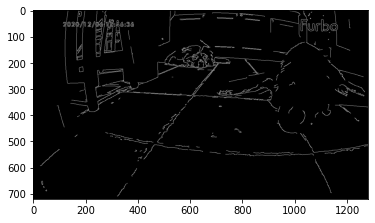

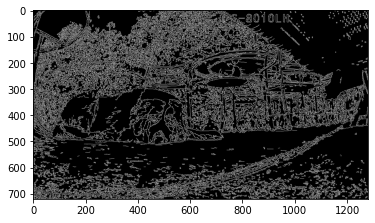

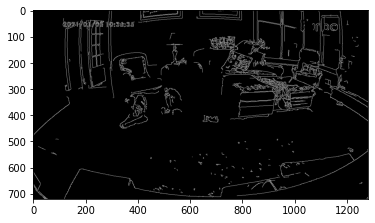

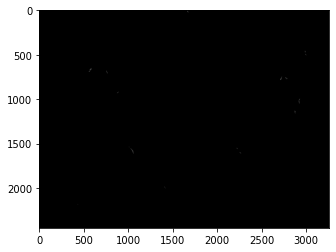

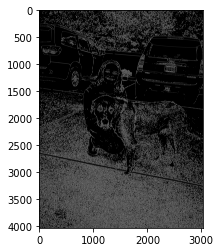

In [ ]:
canny_imgs = []

# Show each image with the applied filter
for t in test_imgs:
  canny = automatic_canny(t)
  canny_imgs.append(canny)
  plt.imshow(canny, cmap='gray')
  plt.show()

### 5. Morphological Transformation - Closing
(https://docs.opencv.org/4.5.2/d9/d61/tutorial_py_morphological_ops.html)

(CPE695-10)

* Simple operations, typically applied on binary images
* Transformations:
  - **Erosion**: 'erodes' boundaries of foreground object
    - If all pixels under kernel are 1, pixel will be 1; else, 0
    - Pixels near boundary of foreground object are discared, so decreases size/thickness of object
    - Good for noise removal if followed by dilation
  - **Dilation**: expands boundaries of foreground object
    - If at least one pixel under kernel is 1, pixel will be 1
    - Object area increases as long as noise first eroded
    - Useful for joining 'broken' parts of an image
  - **Opening**: erosion followed by dilation
    - Useful for noise removal
  - **Closing**: dilation followed by erosion
    - Useful for closing small holes (i.e. areas of discontinuity) in object
    - _Transform of interest for edge closing in image segmentation_
  - **Gradient**: difference between dilation and erosion of an image
    - Result will be foreground object outlined

* Because Canny Edge Detection gave generally the best overall results, will use for testing

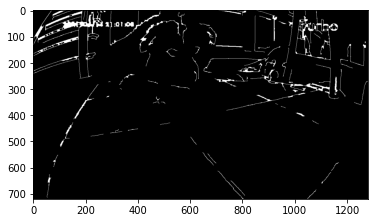

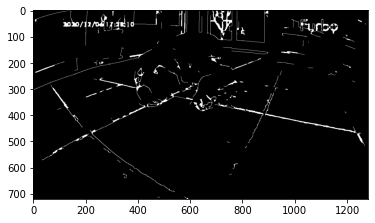

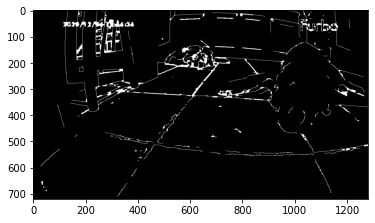

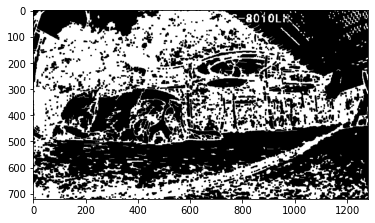

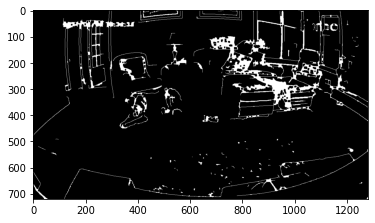

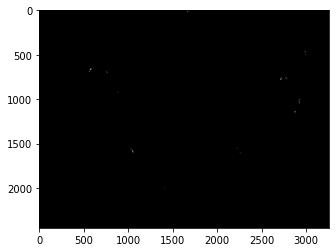

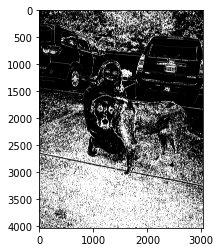

In [ ]:
# Define 5x5 kernel
kernel = np.ones((5, 5), np.uint8)

canny_closed = []

# Apply Morphological Closing transformation on Canny Edge Maps
for c in canny_imgs:
  closed = cv2.morphologyEx(c, cv2.MORPH_CLOSE, kernel)
  canny_closed.append(closed)
  plt.imshow(closed, cmap='gray')
  plt.show()

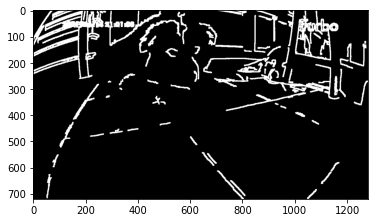

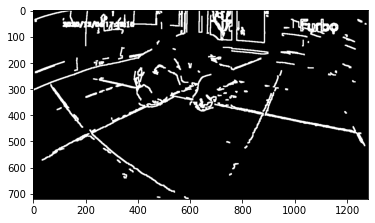

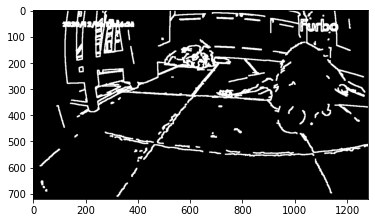

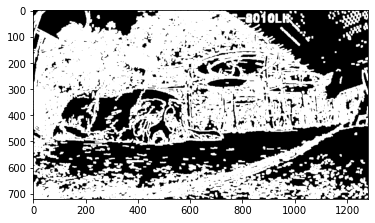

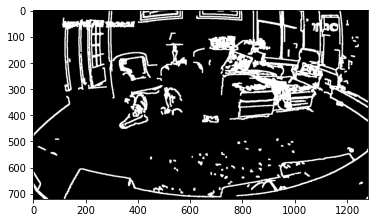

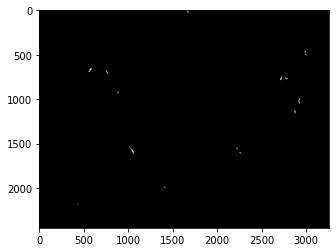

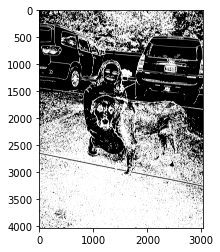

In [ ]:
canny_gradient = []

# Apply Morphological Gradient transformation on Canny Edge Maps (to highlight foreground object)
for c in canny_imgs:
  grad = cv2.morphologyEx(c, cv2.MORPH_GRADIENT, kernel)
  canny_gradient.append(grad)
  plt.imshow(grad, cmap='gray')
  plt.show()

### 6. Additional approach: Contour Detection

(https://www.analyticsvidhya.com/blog/2021/08/edge-contour-detection-an-application-of-computer-vision/)

* After creating edge map and applying morphological transformations, can do contour detection to try to extract objects with distinct edges/shapes 
* Contour detection finds shapes of _closed objects_ (finds continual points with same color intensity)
* On the other hand, edge detection detects rapid change in color intensity

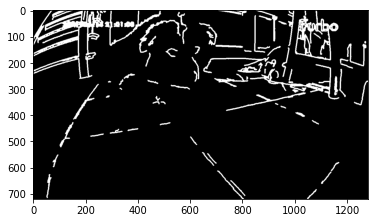

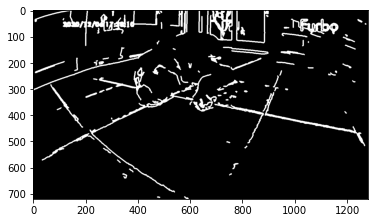

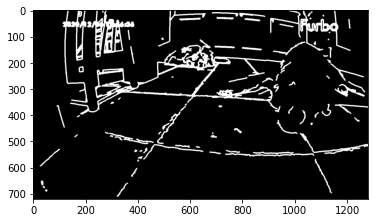

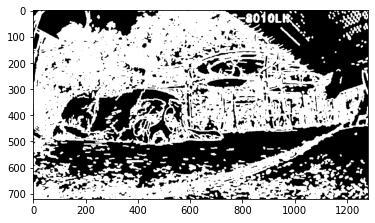

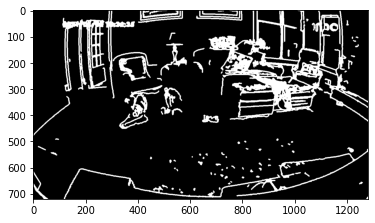

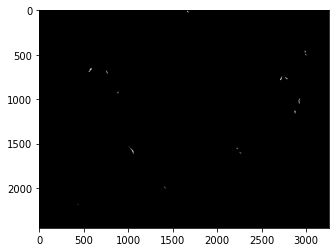

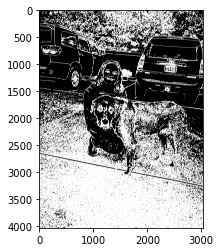

In [ ]:
# Detect contours in closed Canny images
for c in canny_closed:
  contours, _ = cv2.findContours(c, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  draw = c.copy()
  cv2.drawContours(draw, contours, -1, (255, 255, 0), 3)
  plt.imshow(draw, cmap='gray')
  plt.show()

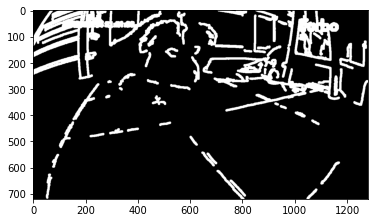

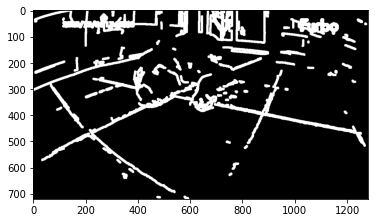

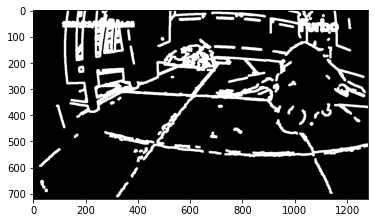

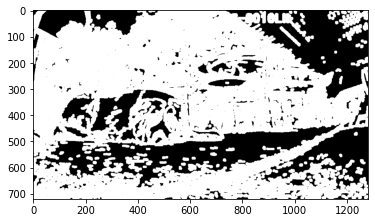

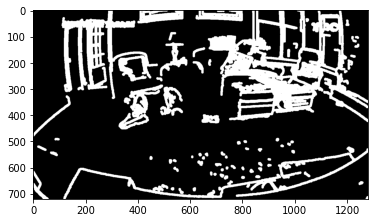

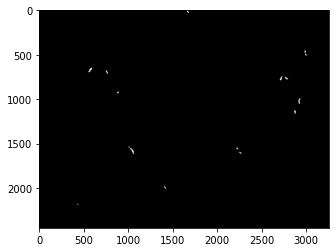

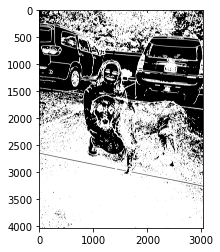

In [ ]:
# Detect contours in gradient Canny images
for c in canny_gradient:
  contours, _ = cv2.findContours(c, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  draw = c.copy()
  cv2.drawContours(draw, contours, -1, (255, 255, 0), 3)
  plt.imshow(draw, cmap='gray')
  plt.show()